In [14]:
import numpy as np

import astropy.units as u
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo

import emcee

import matplotlib.pyplot as plt

In [ ]:
# Tabell 1 från Bakx et al. (2021)
lambda_obs = ([0.427, 0.728, 0.873, 1.33] *  u.mm).to(u.m ).value
flux_rest  = ([154,   180,   143,   60  ] * u.uJy).to(u.Jy).value
flux_error = ([37,    39,    15,    11  ] * u.uJy).to(u.Jy).value

In [ ]:
# Konstanter
h     = const.h.value
c     = const.c.value
k_B   = const.k_B.value
Tcmb0 = cosmo.Tcmb0.value

# Parametrar från sektioner 2 och 3.1 i Bakx et al. (2021)
z          = 7.13
kappa_star = (10.41 * u.cm**2 / u.g).to(u.m**2 / u.kg).value
nu_star    = (1900  * u.GHz).to(u.Hz).value

# Konvertering av våglängderna i tabellen till frekvenser
nu_obs  = c / lambda_obs

# Våglängder och frekvenser i viloram
lambda_rest = lambda_obs / (1 + z)
nu_rest     = nu_obs     * (1 + z)

In [4]:
# Svartkroppsstrålning
B = lambda T, nu: (2 * h * nu**3 / c**2) / (np.exp(h * nu / (k_B * T)) - 1.0)

# Rödförskjutning av bakgrundsstrålning
Tcmb = lambda z: Tcmb0 * (1 + z)

g_z = ((1 + z) / (cosmo.luminosity_distance(z)**2)).to(u.m**-2).value

# Konvertera M_sun till kg
M_sun_to_kg = lambda M_sun: (1 * u.M_sun).to(u.kg).value * M_sun

def SED(nu, T_d, beta_d, M_d): 
    # Från ekv (12) i da Cunha et al. (2013)
    T_corrected = (T_d**(4 + beta_d) + Tcmb0**(4 + beta_d) * ((1 + z)**(4 + beta_d) - 1))**(1 / (4 + beta_d))

    # Från ekv (8) i Sommovigo et al. (2021) som redan bakar in ekv (18) i da Cunha et al. (2013)
    kappa_nu = kappa_star * (nu / nu_star) ** beta_d
    flux = g_z * M_sun_to_kg(M_d) * kappa_nu * (B(T_corrected, nu) - B(Tcmb(z), nu))

    # Konvertera (W * m^-2 * Hz^-1) till Jy
    return flux * 1e26

In [5]:
def log_prob(params):
    T_d, beta_d, M_d = params
    if not (10 < T_d < 100 and 0.2 < beta_d < 2.5 and 1e5 < M_d < 1e10):
        return -np.inf
    
    flux_model = SED(nu_rest, T_d, beta_d, M_d)
    residuals = (flux_rest - flux_model) / flux_error
    return -0.5 * np.sum(residuals**2)

In [6]:
n_walkers = 64

pos = [[np.random.normal(40.0, 5.0), np.random.normal(1.8, 0.2), 10**(np.random.normal(np.log10(1e7), 0.3))] for _ in range(n_walkers)]

sampler = emcee.EnsembleSampler(n_walkers, 3, log_prob)
sampler.run_mcmc(pos, 10000, progress=True)

flat_samples     = sampler.get_chain(discard=2000, thin=30, flat=True)
T_d, beta_d, M_d = np.median(flat_samples, axis=0)

T_d_error    = np.percentile(flat_samples[:, 0], [16, 84])
beta_d_error = np.percentile(flat_samples[:, 1], [16, 84])
M_d_error    = np.percentile(flat_samples[:, 2], [16, 84])

print(f'T_d    = {T_d:.0f}      +{T_d_error[1]-T_d:.0f}/-{T_d-T_d_error[0]:.0f}')
print(f'beta_d = {beta_d:.2f}    +{beta_d_error[1]-beta_d:.2f}/-{beta_d-beta_d_error[0]:.2f}')
print(f'M_d    = {M_d:.1e} +{M_d_error[1]-M_d:.1e}/-{M_d-M_d_error[0]:.1e}')

100%|██████████| 10000/10000 [00:36<00:00, 277.56it/s]

T_d    = 42      +12/-7
beta_d = 1.62    +0.59/-0.72
M_d    = 1.7e+07 +1.3e+07/-7.2e+06


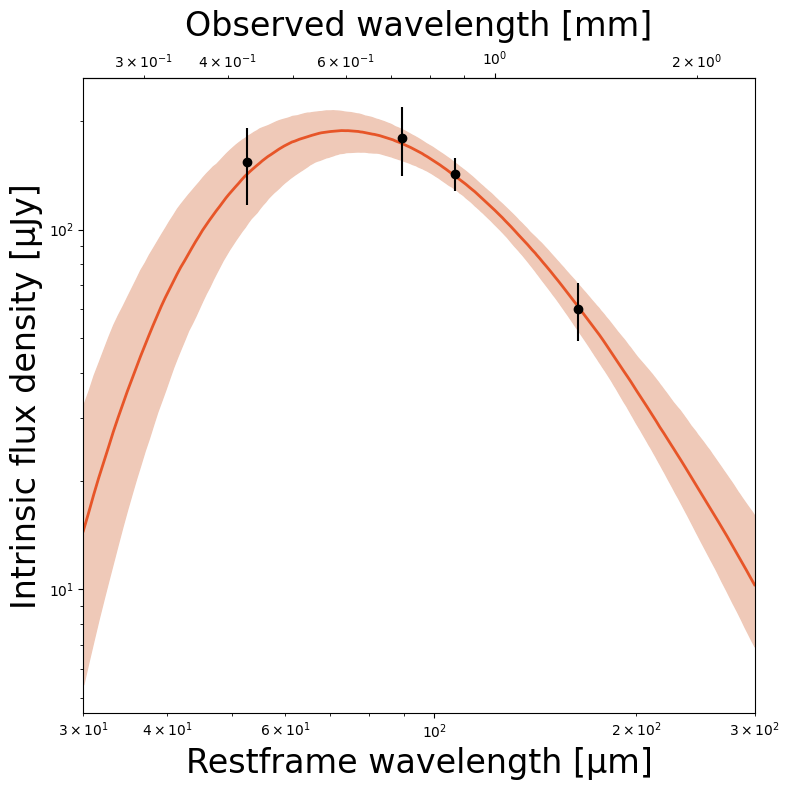

In [46]:
lambda_rest_grid = np.linspace(30, 300, 500) * u.um
nu_rest_grid     = (c * u.m/u.s) / (lambda_rest_grid.to(u.m))

n_draws = 1000
idx = np.random.choice(len(flat_samples), size=n_draws, replace=False)

flux_draws = np.empty((n_draws, len(nu_rest_grid)))
for i, (Tdi, betai, Mdi) in enumerate(flat_samples[idx]):
    flux_draws[i] = SED(nu_rest_grid.value, Tdi, betai, Mdi)

flux_med         = np.median(flux_draws, axis=0)
flux_lo, flux_hi = np.percentile(flux_draws, [16, 84], axis=0)

fig, ax = plt.subplots(figsize=(8,8))

ax.fill_between(lambda_rest_grid.value,
                flux_lo*1e6, flux_hi*1e6,
                color='#efc9b8')

ax.plot(lambda_rest_grid.value, flux_med*1e6,       
        color='#e75528', lw=2)

ax.errorbar(lambda_rest*1e6, flux_rest*1e6,    
            yerr=flux_error*1e6,
            fmt='o', color='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Restframe wavelength [μm]')
ax.set_ylabel('Intrinsic flux density [μJy]')

def um2mm(um):
    return um*(1+z)/1e3

secax = ax.secondary_xaxis('top', functions=(um2mm, lambda x: x/(1+z)*1e3))
secax.set_xlabel('Observed wavelength [mm]')

ax.set_xlim(lambda_rest_grid.value[0], lambda_rest_grid.value[-1])

ax.set_xlabel('Restframe wavelength [μm]', fontsize=24)
ax.set_ylabel('Intrinsic flux density [μJy]', fontsize=24)
secax.set_xlabel('Observed wavelength [mm]', fontsize=24, labelpad=10)

plt.tight_layout()
plt.savefig("SED.pdf")
plt.show()